In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pyhesaff
import matplotlib.patches as patches

#### Using Normal Sift

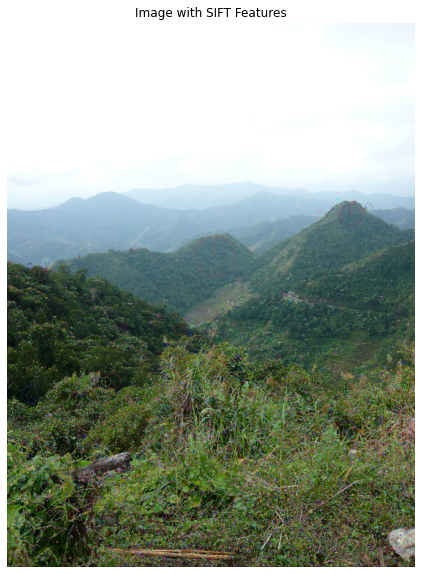

In [5]:

# Load the image
image = cv2.imread('imgs/100000.jpg')

# Convert it to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Create SIFT object
sift = cv2.SIFT_create()

# Detect SIFT features, also known as keypoints and descriptors
keypoints, descriptors = sift.detectAndCompute(gray_image, None)

# Draw keypoints on the image
keypoint_image = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the image with keypoints
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(cv2.cvtColor(keypoint_image, cv2.COLOR_BGR2RGB))
plt.title('Image with SIFT Features')
plt.show()

In [7]:
def draw_ellipses(img, keypoints, scale_factor=100):
    img = img.copy()
    for keypoint in keypoints:
        u, v, a, b, c = keypoint[:5]
        # Constructing the matrix from a, b, c
        M = np.array([[a, b], [b, c]])
        # Eigenvalue decomposition
        eigenvals, eigenvecs = np.linalg.eigh(M)

        # Ensure no division by zero or very small values that lead to invisibility
        eigenvals = np.maximum(eigenvals, 1e-10)

        # Calculate the angle of orientation
        angle = np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0])
        # Axes lengths (inverse square root of eigenvalues gives axes lengths)
        # Scaling up the axes to ensure visibility
        width = np.sqrt(1 / eigenvals[0]) * scale_factor
        height = np.sqrt(1 / eigenvals[1]) * scale_factor
        angle_deg = np.degrees(angle)
        
        # Draw the ellipse, rounding to nearest integer for actual drawing
        cv2.ellipse(img, (int(u), int(v)), (int(width), int(height)), angle_deg, 0, 360, (0, 0, 255), 2)  # Green ellipse with thickness 2

    return img

In [8]:
def get_ellipse_properties(keypoints):
    properties = []
    for keypoint in keypoints:
        u, v, a, b, c = keypoint[:5]
        # Constructing the matrix from a, b, c
        
        A = np.array([[a, b], [b, c]])

        # Eigen decomposition
        eigenvalues, eigenvectors = np.linalg.eig(A)

        # Order eigenvalues and eigenvectors
        sorted_indices = np.argsort(eigenvalues)
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        # Scale (using the smallest eigenvalue for the semi-major axis)
        scale_si = np.sqrt(1/eigenvalues[0])

        # Orientation (angle from the horizontal axis)
        orientation_oi = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * (180 / np.pi) 
        properties.append((u, v, scale_si, orientation_oi))
    return properties

#### Using Hessian Affine Sift

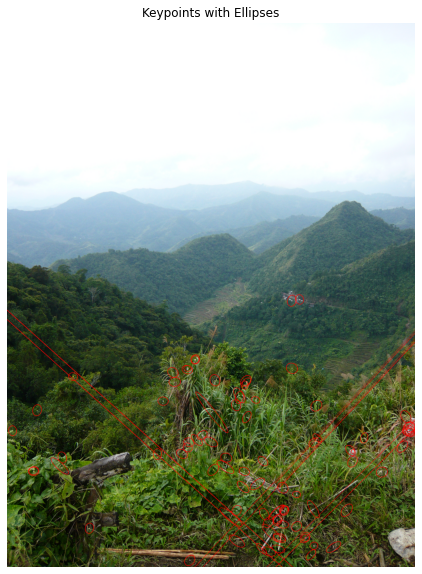

In [9]:
img_path_1 = 'imgs/100000.jpg'
img = cv2.imread(img_path_1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect keypoints and descriptors using pyhesaff
keypoints1, descriptors1 = pyhesaff.detect_feats(img_path_1, numberOfScales= 3,threshold=30)

# Draw ellipses around each keypoint with a scale factor for better visibility
img_with_ellipses = draw_ellipses(img, keypoints1, scale_factor=100)

# Display the image with keypoints and ellipses
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(cv2.cvtColor(img_with_ellipses, cv2.COLOR_BGR2RGB))
plt.title('Keypoints with Ellipses')
plt.show()

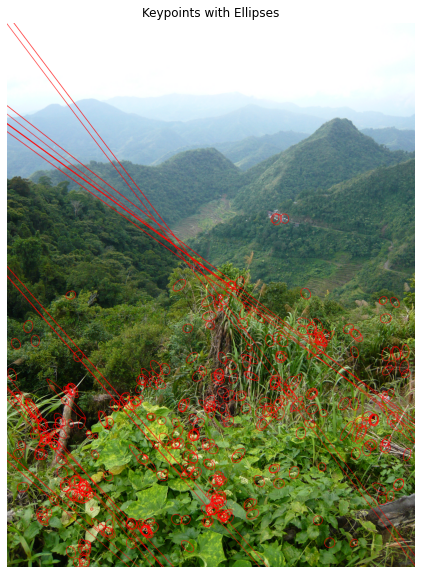

In [11]:
img_path_2 = 'imgs/100001.jpg'
img_r = cv2.imread(img_path_2)
gray = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)

# Detect keypoints and descriptors using pyhesaff
keypoints2, descriptors2 = pyhesaff.detect_feats(img_path_2, numberOfScales= 3,threshold=30)

# Draw ellipses around each keypoint with a scale factor for better visibility
img_with_ellipses = draw_ellipses(img_r, keypoints2, scale_factor=100)

# Display the image with keypoints and ellipses
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(cv2.cvtColor(img_with_ellipses, cv2.COLOR_BGR2RGB))
plt.title('Keypoints with Ellipses')
plt.show()

In [12]:
keypoints1_tocv = [keypoint[:2] for keypoint in keypoints1]
keypoints2_tocv = [keypoint[:2] for keypoint in keypoints2]
keypoints_cv1 = [cv2.KeyPoint(x=u, y=v, size=15) for (u, v) in keypoints1_tocv]
keypoints_cv2 = [cv2.KeyPoint(x=u, y=v, size=15) for (u, v) in keypoints2_tocv]


In [14]:
# Create a BFMatcher object
# For SIFT or SURF, cv2.NORM_L2 is usually used
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors.
matches = matcher.match(descriptors1, descriptors2)

# Sort them in the order of their distance (the lower the distance, the better the match).
matches = sorted(matches, key=lambda x: x.distance)

# Optionally, filter matches (e.g., by applying a distance threshold or Lowe's ratio test)
# Here, we keep only the top 50 matches for visualization
good_matches = matches[:20]



# Draw matches
matched_image = cv2.drawMatches(img, keypoints_cv1, img_r, keypoints_cv2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched image
cv2.imshow('Matches', matched_image)
cv2.waitKey(0)
cv2.destroyAllWindows()